<a id='ldata'></a>
 <a id = "11115"></a><br>

<div>  
<h1><center style="background-color:#c0c0c0; color:black;"><strong>  📈Store Item Demand Forecasting🚀  </strong></center></h1>
</div>

<img src="https://www.veryableops.com/hubfs/demand%20forecasting.jpg" width="600">

<a id='ldata'></a>
 <a id = "11115"></a><br>

<div>  
<h1><center style="background-color:#c0c0c0; color:black;"><strong>TABLE OF CONTENTS </strong></center></h1>
</div>

1. [Description](#1)
2. [Loading libraries and data](#2)
3. [Understanding the data](#3)

4. [Date Features](#4)
5. [Lag/Shifted Features](#5)
6. [Rolling Mean Features](#6)
7. [Exponentially Weighted Mean Features](#7)
8. [Special Days](#8)
9. [One-Hot Encoding](#9)
10. [Custom Cost Function](#10)

11. [Train,Test, and Validation Sets](#11)
12. [LightGBM Model](#12)
13. [SMAPE](#13)
14. [Result](#14)

<a id='ldata'></a>
 <a id = "1"></a><br>

<div>  
<h1><center style="background-color:#c0c0c0; color:black;"><strong>1. DESCRIPTION </strong></center></h1>
</div>
<a id="Description"></a>

<div style="border-radius:10px;
            border : black solid;
            background-color: #FFFFF;
            font-size:110%;
            text-align: left">

    
    
We are asked to explore different time series techniques on a relatively simple and clean dataset.

You are given 5 years of store-item sales data, and asked to predict 3 months of sales for 50 different items at 10 different stores.

#### Variables

* **date**
* **store**
* **item**
* **sales**



<a id = "2" ></a>
# <span style="font-family:serif; font-size:28px;"> 2. Loading libraries and data</span>
<a id="loading"></a>

In [1]:
import time
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
import lightgbm as lgb
import warnings

pd.set_option('display.max_columns', None)
pd.set_option('display.width', 500)
warnings.filterwarnings('ignore')

In [2]:
#load dataset
df_copy= pd.read_csv('train.csv', parse_dates=['date'])
df=df_copy.copy()

<a id = "3" ></a>
# <span style="font-family:serif; font-size:28px;"> 3. Understanding the data</span>
<a id = "Undertanding the data" ></a>

In [3]:
df

,date,store,item,sales
0,2013-01-01,1,1,13
1,2013-01-02,1,1,11
2,2013-01-03,1,1,14
3,2013-01-04,1,1,13
4,2013-01-05,1,1,10
...,...,...,...,...
913018,2017-12-27,10,50,63
913019,2017-12-28,10,50,59
913020,2017-12-29,10,50,74
913021,2017-12-30,10,50,62


In [4]:
df["store"].nunique()

10

In [5]:
df["item"].nunique()

50

In [6]:
df.shape

(913023, 4)

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 913023 entries, 0 to 913022
Data columns (total 4 columns):
 #   Column  Non-Null Count   Dtype         
---  ------  --------------   -----         
 0   date    913023 non-null  datetime64[ns]
 1   store   913023 non-null  int64         
 2   item    913023 non-null  int64         
 3   sales   913023 non-null  int64         
dtypes: datetime64[ns](1), int64(3)
memory usage: 27.9 MB


In [8]:
df.quantile([0,0.01, 0.05, 0.25, 0.50, 0.75, 0.95, 0.99, 1]).T

,0.00,0.01,0.05,0.25,0.50,0.75,0.95,0.99,1.00
store,1.0,1.0,1.0,3.0,5.0,8.0,10.0,10.0,10.0
item,1.0,1.0,3.0,13.0,25.0,38.0,48.0,50.0,50.0
sales,0.0,10.0,16.0,30.0,47.0,70.0,107.0,135.0,231.0


In [9]:
merchant_ids=df["store"].unique()
merchant_ids

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10], dtype=int64)

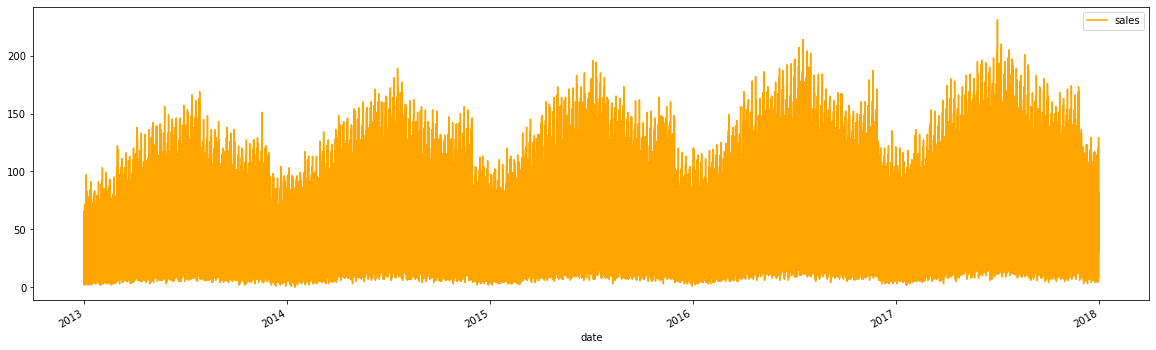

In [10]:
# all stores sales
dfx=df.copy()
forecast = pd.DataFrame({
    "date":dfx.date,
    "sales":dfx.sales
})

forecast.set_index("date").sales.plot(color = "orange", figsize = (20,6),legend=True);

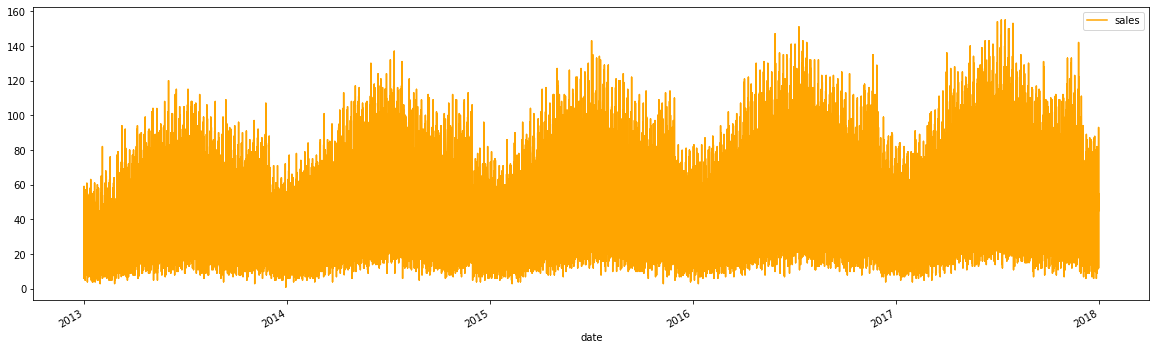

In [11]:
# just store==1 sales
dfx=df[df["store"]==1]
forecast = pd.DataFrame({
    "date":dfx.date,
    "sales":dfx.sales
})

forecast.set_index("date").sales.plot(color = "orange", figsize = (20,6),legend=True);

<a id = "4" ></a>
# <span style="font-family:serif; font-size:28px;"> 4. Date Features</span>
<a id = "Undertanding the data" ></a>

In [12]:
def create_date_features(df):
    df['month'] = df.date.dt.month
    df['day_of_month'] = df.date.dt.day
    df['day_of_year'] = df.date.dt.dayofyear
    df['week_of_year'] = df.date.dt.weekofyear
    df['day_of_week'] = df.date.dt.dayofweek
    df['year'] = df.date.dt.year
    df["is_wknd"] = df.date.dt.weekday // 4
    df['is_month_start'] = df.date.dt.is_month_start.astype(int)
    df['is_month_end'] = df.date.dt.is_month_end.astype(int)
    return df

df = create_date_features(df)
df.head(3)

,date,store,item,sales,month,day_of_month,day_of_year,week_of_year,day_of_week,year,is_wknd,is_month_start,is_month_end
0,2013-01-01,1,1,13,1,1,1,1,1,2013,0,1,0
1,2013-01-02,1,1,11,1,2,2,1,2,2013,0,0,0
2,2013-01-03,1,1,14,1,3,3,1,3,2013,0,0,0


<AxesSubplot:xlabel='store'>

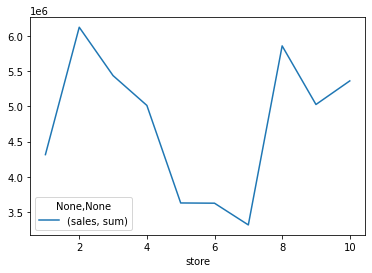

In [13]:
df.groupby(["store"]).agg({"sales": ["sum"]}).plot()

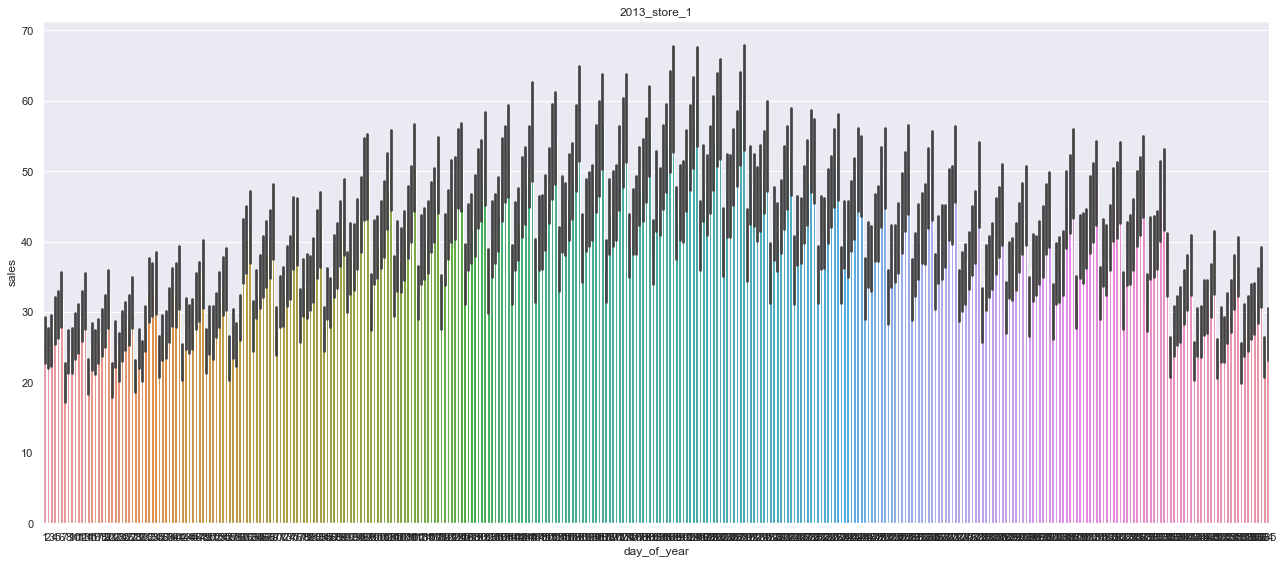

In [14]:
# store==1  & year==2013 sales
for store in df.store.unique()[:1]:
    for year in df.year.unique()[:1]:
        plt.figure(figsize=(18, 8))
        sns.set(font_scale=1)
        sns.barplot(x="day_of_year", y="sales", data=df[(df["store"]==store)&(df["year"]==year)])
        plt.title(str(year)+"_store_"+str(store))
        plt.tight_layout()
        plt.show()
        break

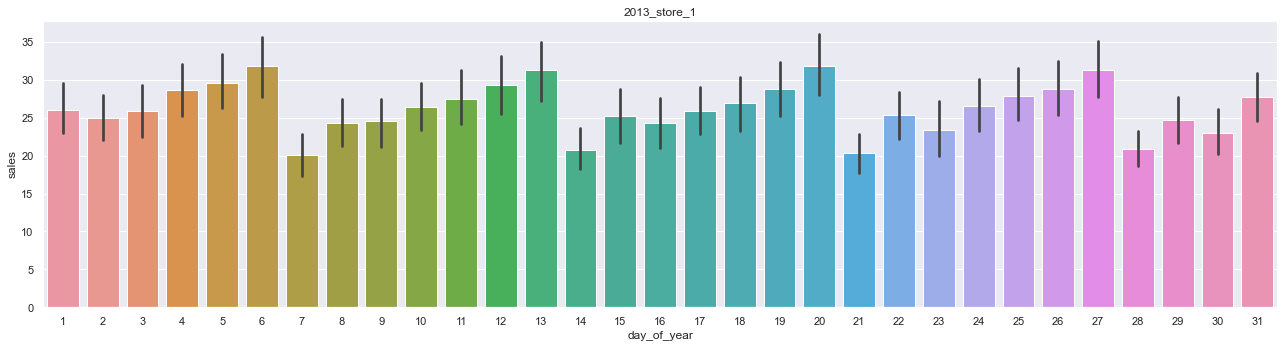

In [15]:
# store==1  & year==2013  & month==1 sales 
for store in df.store.unique()[:1]:
    for year in df.year.unique()[:1]:
        for month in df.month.unique()[:1]:
            plt.figure(figsize=(18, 5))
            sns.set(font_scale=1)
            sns.barplot(x="day_of_year", y="sales", data=df[(df["store"]==store)&(df["year"]==year)&(df["month"]==month)])
            plt.title(str(year)+"_store_"+str(store))
            plt.tight_layout()
            plt.show()

In [16]:
########################
# Random Noise
########################

def random_noise(dataframe):
    return np.random.normal(scale=1.6, size=(len(dataframe),))

<a id = "5" ></a>
# <span style="font-family:serif; font-size:28px;"> 5. Lag/Shifted Features</span>
<a id = "Undertanding the data" ></a>

In [17]:
df.sort_values(by=['store', 'date'], axis=0, inplace=True)
df.head(3)

,date,store,item,sales,month,day_of_month,day_of_year,week_of_year,day_of_week,year,is_wknd,is_month_start,is_month_end
0,2013-01-01,1,1,13,1,1,1,1,1,2013,0,1,0
24,2013-01-01,1,1,13,1,1,1,1,1,2013,0,1,0
18283,2013-01-01,1,2,33,1,1,1,1,1,2013,0,1,0


In [18]:
def lag_features(dataframe, lags):
    for lag in lags:
        dataframe['sales_lag_' + str(lag)] = dataframe.groupby(["store","item"])['sales'].transform(
            lambda x: x.shift(lag)) + random_noise(dataframe)
    return dataframe

df = lag_features(df, [91, 98, 105, 112, 119, 126, 182, 364, 546, 728])
df

,date,store,item,sales,month,day_of_month,day_of_year,week_of_year,day_of_week,year,is_wknd,is_month_start,is_month_end,sales_lag_91,sales_lag_98,sales_lag_105,sales_lag_112,sales_lag_119,sales_lag_126,sales_lag_182,sales_lag_364,sales_lag_546,sales_lag_728
0,2013-01-01,1,1,13,1,1,1,1,1,2013,0,1,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
24,2013-01-01,1,1,13,1,1,1,1,1,2013,0,1,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
18283,2013-01-01,1,2,33,1,1,1,1,1,2013,0,1,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
36543,2013-01-01,1,3,15,1,1,1,1,1,2013,0,1,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
54803,2013-01-01,1,4,10,1,1,1,1,1,2013,0,1,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
839982,2017-12-31,10,46,70,12,31,365,52,6,2017,1,0,1,71.384863,92.137617,80.873014,102.819049,94.080449,98.604546,101.374810,70.921728,106.457264,51.173102
858242,2017-12-31,10,47,22,12,31,365,52,6,2017,1,0,1,32.714993,30.889485,31.262722,30.678884,26.683706,42.039638,39.385519,27.098877,42.371137,17.293289
876502,2017-12-31,10,48,60,12,31,365,52,6,2017,1,0,1,78.778318,84.496229,79.498995,99.227254,81.475706,93.899551,110.600057,52.455622,101.323065,51.446003
894762,2017-12-31,10,49,42,12,31,365,52,6,2017,1,0,1,37.864647,44.331626,46.250354,37.998425,48.830447,53.450047,61.541515,41.422796,67.278089,32.112455


<a id = "6" ></a>
# <span style="font-family:serif; font-size:28px;"> 6. Rolling Mean Features</span>
<a id = "Undertanding the data" ></a>

In [19]:
def roll_mean_features(dataframe, windows):
    for window in windows:
        dataframe['sales_roll_mean_' + str(window)] = dataframe.groupby(["store"])['sales']. \
                                                          transform(
            lambda x: x.shift(1).rolling(window=window, min_periods=10, win_type="triang").mean()) + random_noise(
            dataframe)
    return dataframe


df = roll_mean_features(df, [91,120,182,365, 546,728])
df

,date,store,item,sales,month,day_of_month,day_of_year,week_of_year,day_of_week,year,is_wknd,is_month_start,is_month_end,sales_lag_91,sales_lag_98,sales_lag_105,sales_lag_112,sales_lag_119,sales_lag_126,sales_lag_182,sales_lag_364,sales_lag_546,sales_lag_728,sales_roll_mean_91,sales_roll_mean_120,sales_roll_mean_182,sales_roll_mean_365,sales_roll_mean_546,sales_roll_mean_728
0,2013-01-01,1,1,13,1,1,1,1,1,2013,0,1,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
24,2013-01-01,1,1,13,1,1,1,1,1,2013,0,1,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
18283,2013-01-01,1,2,33,1,1,1,1,1,2013,0,1,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
36543,2013-01-01,1,3,15,1,1,1,1,1,2013,0,1,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
54803,2013-01-01,1,4,10,1,1,1,1,1,2013,0,1,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
839982,2017-12-31,10,46,70,12,31,365,52,6,2017,1,0,1,71.384863,92.137617,80.873014,102.819049,94.080449,98.604546,101.374810,70.921728,106.457264,51.173102,53.762217,57.586144,54.699098,48.469722,47.995613,47.734136
858242,2017-12-31,10,47,22,12,31,365,52,6,2017,1,0,1,32.714993,30.889485,31.262722,30.678884,26.683706,42.039638,39.385519,27.098877,42.371137,17.293289,58.659937,56.682167,53.034910,50.083492,50.256480,47.121713
876502,2017-12-31,10,48,60,12,31,365,52,6,2017,1,0,1,78.778318,84.496229,79.498995,99.227254,81.475706,93.899551,110.600057,52.455622,101.323065,51.446003,57.120073,56.871220,55.980277,47.987859,47.190230,49.974980
894762,2017-12-31,10,49,42,12,31,365,52,6,2017,1,0,1,37.864647,44.331626,46.250354,37.998425,48.830447,53.450047,61.541515,41.422796,67.278089,32.112455,55.584119,53.954456,52.293952,49.753339,49.618915,49.372159


<a id = "7" ></a>
# <span style="font-family:serif; font-size:28px;"> 7. Exponentially Weighted Mean Features</span>
<a id = "Undertanding the data" ></a>

In [20]:
########################
# Exponentially Weighted Mean Features
########################

def ewm_features(dataframe, alphas, lags):
    for alpha in alphas:
        for lag in lags:
            dataframe['sales_ewm_alpha_' + str(alpha).replace(".", "") + "_lag_" + str(lag)] = \
                dataframe.groupby(["store"])['sales'].transform(lambda x: x.shift(lag).ewm(alpha=alpha).mean())
    return dataframe

alphas = [0.95, 0.9, 0.8, 0.7, 0.5]
lags = [91, 98, 105, 112, 180, 270, 365, 546, 728]

df = ewm_features(df, alphas, lags)
df

,date,store,item,sales,month,day_of_month,day_of_year,week_of_year,day_of_week,year,is_wknd,is_month_start,is_month_end,sales_lag_91,sales_lag_98,sales_lag_105,sales_lag_112,sales_lag_119,sales_lag_126,sales_lag_182,sales_lag_364,sales_lag_546,sales_lag_728,sales_roll_mean_91,sales_roll_mean_120,sales_roll_mean_182,sales_roll_mean_365,sales_roll_mean_546,sales_roll_mean_728,sales_ewm_alpha_095_lag_91,sales_ewm_alpha_095_lag_98,sales_ewm_alpha_095_lag_105,sales_ewm_alpha_095_lag_112,sales_ewm_alpha_095_lag_180,sales_ewm_alpha_095_lag_270,sales_ewm_alpha_095_lag_365,sales_ewm_alpha_095_lag_546,sales_ewm_alpha_095_lag_728,sales_ewm_alpha_09_lag_91,sales_ewm_alpha_09_lag_98,sales_ewm_alpha_09_lag_105,sales_ewm_alpha_09_lag_112,sales_ewm_alpha_09_lag_180,sales_ewm_alpha_09_lag_270,sales_ewm_alpha_09_lag_365,sales_ewm_alpha_09_lag_546,sales_ewm_alpha_09_lag_728,sales_ewm_alpha_08_lag_91,sales_ewm_alpha_08_lag_98,sales_ewm_alpha_08_lag_105,sales_ewm_alpha_08_lag_112,sales_ewm_alpha_08_lag_180,sales_ewm_alpha_08_lag_270,sales_ewm_alpha_08_lag_365,sales_ewm_alpha_08_lag_546,sales_ewm_alpha_08_lag_728,sales_ewm_alpha_07_lag_91,sales_ewm_alpha_07_lag_98,sales_ewm_alpha_07_lag_105,sales_ewm_alpha_07_lag_112,sales_ewm_alpha_07_lag_180,sales_ewm_alpha_07_lag_270,sales_ewm_alpha_07_lag_365,sales_ewm_alpha_07_lag_546,sales_ewm_alpha_07_lag_728,sales_ewm_alpha_05_lag_91,sales_ewm_alpha_05_lag_98,sales_ewm_alpha_05_lag_105,sales_ewm_alpha_05_lag_112,sales_ewm_alpha_05_lag_180,sales_ewm_alpha_05_lag_270,sales_ewm_alpha_05_lag_365,sales_ewm_alpha_05_lag_546,sales_ewm_alpha_05_lag_728
0,2013-01-01,1,1,13,1,1,1,1,1,2013,0,1,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
24,2013-01-01,1,1,13,1,1,1,1,1,2013,0,1,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
18283,2013-01-01,1,2,33,1,1,1,1,1,2013,0,1,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
36543,2013-01-01,1,3,15,1,1,1,1,1,2013,0,1,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
54803,2013-01-01,1,4,10,1,1,1,1,1,2013,0,1,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
839982,2017-12-31,10,46,70,12,31,365,52,6,2017,1,0,1,71.384863,92.137617,80.873014,102.819049,94.080449,98.604546,101.374810,70.921728,106.457264,51.173102,53.762217,57.586144,54.699098,48.469722,47.995613,47.734136,20.750077,57.077619,26.382076,26.657018,30.936562,31.333826,60.350101,49.428698,89.254758,20.609435,55.409004,26.853415,29.135475,33.751976,32.713038,59.807754,48.001225,86.456355,20.700631,52.802767,28.180654,33.597651,39.047524,35.499051,59.057083,45.516289,80.908216,21.348131,51.071825,30.143451,37.474371,43.927162,38.189055,58.706690,43.468554,75.747272,24.558175,49.446348,36.132571,43.969064,52.431854,42.847973,58.768407,40.631621,68.060261
85824

In [21]:
df.groupby(["day_of_year"]).agg({"sales": ["sum"]})

,sales
,sum
day_of_year,
1,90358
2,86493
3,93607
4,89684
5,88365
...,...
362,97760
363,95534


<a id = "8" ></a>
# <span style="font-family:serif; font-size:28px;"> 8. Special Days</span>
<a id = "Undertanding the data" ></a>

In [22]:
imported_days=[]
ort_=df["sales"].mean()
for day in df["day_of_year"].unique():
    dfx=df[df["day_of_year"]==day]["sales"]
    if int(100*dfx.mean()/ort_)<75 or int(100*dfx.mean()/ort_)>125:
        imported_days.append(day)
        if len(imported_days)<10:
            print("day : ",day,"diff % ",int(100*dfx.mean()/ort_))
        

day :  1 diff %  69
day :  2 diff %  66
day :  3 diff %  71
day :  4 diff %  68
day :  5 diff %  67
day :  6 diff %  65
day :  7 diff %  65
day :  8 diff %  69
day :  9 diff %  66


In [23]:
for day in imported_days:
    df["day_"+str(day)]=0
    df.loc[df[df["day_of_year"]==day].index,"day_"+str(day)]=1
df

,date,store,item,sales,month,day_of_month,day_of_year,week_of_year,day_of_week,year,is_wknd,is_month_start,is_month_end,sales_lag_91,sales_lag_98,sales_lag_105,sales_lag_112,sales_lag_119,sales_lag_126,sales_lag_182,sales_lag_364,sales_lag_546,sales_lag_728,sales_roll_mean_91,sales_roll_mean_120,sales_roll_mean_182,sales_roll_mean_365,sales_roll_mean_546,sales_roll_mean_728,sales_ewm_alpha_095_lag_91,sales_ewm_alpha_095_lag_98,sales_ewm_alpha_095_lag_105,sales_ewm_alpha_095_lag_112,sales_ewm_alpha_095_lag_180,sales_ewm_alpha_095_lag_270,sales_ewm_alpha_095_lag_365,sales_ewm_alpha_095_lag_546,sales_ewm_alpha_095_lag_728,sales_ewm_alpha_09_lag_91,sales_ewm_alpha_09_lag_98,sales_ewm_alpha_09_lag_105,sales_ewm_alpha_09_lag_112,sales_ewm_alpha_09_lag_180,sales_ewm_alpha_09_lag_270,sales_ewm_alpha_09_lag_365,sales_ewm_alpha_09_lag_546,sales_ewm_alpha_09_lag_728,sales_ewm_alpha_08_lag_91,sales_ewm_alpha_08_lag_98,sales_ewm_alpha_08_lag_105,sales_ewm_alpha_08_lag_112,sales_ewm_alpha_08_lag_180,sales_ewm_alpha_08_lag_270,sales_ewm_alpha_08_lag_365,sales_ewm_alpha_08_lag_546,sales_ewm_alpha_08_lag_728,sales_ewm_alpha_07_lag_91,sales_ewm_alpha_07_lag_98,sales_ewm_alpha_07_lag_105,sales_ewm_alpha_07_lag_112,sales_ewm_alpha_07_lag_180,sales_ewm_alpha_07_lag_270,sales_ewm_alpha_07_lag_365,sales_ewm_alpha_07_lag_546,sales_ewm_alpha_07_lag_728,sales_ewm_alpha_05_lag_91,sales_ewm_alpha_05_lag_98,sales_ewm_alpha_05_lag_105,sales_ewm_alpha_05_lag_112,sales_ewm_alpha_05_lag_180,sales_ewm_alpha_05_lag_270,sales_ewm_alpha_05_lag_365,sales_ewm_alpha_05_lag_546,sales_ewm_alpha_05_lag_728,day_1,day_2,day_3,day_4,day_5,day_6,day_7,day_8,day_9,day_10,day_11,day_12,day_13,day_14,day_15,day_16,day_17,day_18,day_19,day_20,day_21,day_22,day_23,day_24,day_25,day_26,day_27,day_28,day_29,day_30,day_31,day_34,day_35,day_37,day_41,day_42,day_44,day_47,day_48,day_49,day_51,day_55,day_56,day_58,day_157,day_164,day_171,day_178,day_183,day_185,day_186,day_187,day_190,day_192,day_193,day_194,day_197,day_199,day_200,day_201,day_204,day_206,day_207,day_208,day_211,day_336,day_338,day_341,day_342,day_343,day_345,day_349,day_350,day_352,day_356,day_357,day_359,day_362,day_363,day_364
0,2013-01-01,1,1,13,1,1,1,1,1,2013,0,1,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
24,2013-01-01,1,1,13,1,1,1,1,1,2013,0,1,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
18283,2013-01-01,1,2,33,1,1,1,1,1,2013,0,1,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
36543,2013-01-01,1,3,15,1,1,1,1,1,2013,0,1,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
54803,2013-01-01,1,4,10,1,1,1,1,1

<a id = "9" ></a>
# <span style="font-family:serif; font-size:28px;"> 9. One-Hot Encoding</span>
<a id = "Undertanding the data" ></a>

In [24]:
df = pd.get_dummies(df, columns=['store',"item",'day_of_week', "week_of_year",'month'])
df

,date,sales,day_of_month,day_of_year,year,is_wknd,is_month_start,is_month_end,sales_lag_91,sales_lag_98,sales_lag_105,sales_lag_112,sales_lag_119,sales_lag_126,sales_lag_182,sales_lag_364,sales_lag_546,sales_lag_728,sales_roll_mean_91,sales_roll_mean_120,sales_roll_mean_182,sales_roll_mean_365,sales_roll_mean_546,sales_roll_mean_728,sales_ewm_alpha_095_lag_91,sales_ewm_alpha_095_lag_98,sales_ewm_alpha_095_lag_105,sales_ewm_alpha_095_lag_112,sales_ewm_alpha_095_lag_180,sales_ewm_alpha_095_lag_270,sales_ewm_alpha_095_lag_365,sales_ewm_alpha_095_lag_546,sales_ewm_alpha_095_lag_728,sales_ewm_alpha_09_lag_91,sales_ewm_alpha_09_lag_98,sales_ewm_alpha_09_lag_105,sales_ewm_alpha_09_lag_112,sales_ewm_alpha_09_lag_180,sales_ewm_alpha_09_lag_270,sales_ewm_alpha_09_lag_365,sales_ewm_alpha_09_lag_546,sales_ewm_alpha_09_lag_728,sales_ewm_alpha_08_lag_91,sales_ewm_alpha_08_lag_98,sales_ewm_alpha_08_lag_105,sales_ewm_alpha_08_lag_112,sales_ewm_alpha_08_lag_180,sales_ewm_alpha_08_lag_270,sales_ewm_alpha_08_lag_365,sales_ewm_alpha_08_lag_546,sales_ewm_alpha_08_lag_728,sales_ewm_alpha_07_lag_91,sales_ewm_alpha_07_lag_98,sales_ewm_alpha_07_lag_105,sales_ewm_alpha_07_lag_112,sales_ewm_alpha_07_lag_180,sales_ewm_alpha_07_lag_270,sales_ewm_alpha_07_lag_365,sales_ewm_alpha_07_lag_546,sales_ewm_alpha_07_lag_728,sales_ewm_alpha_05_lag_91,sales_ewm_alpha_05_lag_98,sales_ewm_alpha_05_lag_105,sales_ewm_alpha_05_lag_112,sales_ewm_alpha_05_lag_180,sales_ewm_alpha_05_lag_270,sales_ewm_alpha_05_lag_365,sales_ewm_alpha_05_lag_546,sales_ewm_alpha_05_lag_728,day_1,day_2,day_3,day_4,day_5,day_6,day_7,day_8,day_9,day_10,day_11,day_12,day_13,day_14,day_15,day_16,day_17,day_18,day_19,day_20,day_21,day_22,day_23,day_24,day_25,day_26,day_27,day_28,day_29,day_30,day_31,day_34,day_35,day_37,day_41,day_42,day_44,day_47,day_48,day_49,day_51,day_55,day_56,day_58,day_157,day_164,day_171,day_178,day_183,day_185,day_186,day_187,day_190,day_192,day_193,day_194,day_197,day_199,day_200,day_201,day_204,day_206,day_207,day_208,day_211,day_336,day_338,day_341,day_342,day_343,day_345,day_349,day_350,day_352,day_356,day_357,day_359,day_362,day_363,day_364,store_1,store_2,store_3,store_4,store_5,store_6,store_7,store_8,store_9,store_10,item_1,item_2,item_3,item_4,item_5,item_6,item_7,item_8,item_9,item_10,item_11,item_12,item_13,item_14,item_15,item_16,item_17,item_18,item_19,item_20,item_21,item_22,item_23,item_24,item_25,item_26,item_27,item_28,item_29,item_30,item_31,item_32,item_33,item_34,item_35,item_36,item_37,item_38,item_39,item_40,item_41,item_42,item_43,item_44,item_45,item_46,item_47,item_48,item_49,item_50,day_of_week_0,day_of_week_1,day_of_week_2,day_of_week_3,day_of_week_4,day_of_week_5,day_of_week_6,week_of_year_1,week_of_year_2,week_of_year_3,week_of_year_4,week_of_year_5,week_of_year_6,week_of_year_7,week_of_year_8,week_of_year_9,week_of_year_10,week_of_year_11,week_of_year_12,week_of_year_13,week_of_year_14,week_of_year_15,week_of_year_16,week_of_year_17,week_of_year_18,week_of_year_19,week_of_year_20,week_of_year_21,week_of_year_22,week_of_year_23,week_of_year_24,week_of_year_25,week_of_year_26,week_of_year_27,week_of_year_28,week_of_year_29,week_of_year_30,week_of_year_31,week_of_year_32,week_of_year_33,week_of_year_34,week_of_year_35,week_of_year_36,week_of_year_37,week_of_year_38,week_of_year_39,week_of_year_40,week_of_year_41,week_of_year_42,week_of_year_43,week_of_year_44,week_of_year_45,week_of_year_46,week_of_year_47,week_of_year_48,week_of_year_49,week_of_year_50,week_of_year_51,week_of_year_52,week_of_year_53,month_1,month_2,month_3,month_4,month_5,month_6,month_7,month_8,month_9,month_10,month_11,month_12
0,2013-01-01,13,1,1,2013,0,1,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0

In [25]:
########################
# Converting sales to log(1+sales)
########################

df['sales'] = np.log1p(df["sales"].values)

<a id = "10" ></a>
# <span style="font-family:serif; font-size:28px;"> 10. Custom Cost Function</span>
<a id = "Undertanding the data" ></a>

In [26]:
########################
# Custom Cost Function
########################

# MAE, MSE, RMSE, SSE

# MAE: mean absolute error
# MAPE: mean absolute percentage error
# SMAPE: Symmetric mean absolute percentage error (adjusted MAPE)

def smape(preds, target):
    n = len(preds)
    masked_arr = ~((preds == 0) & (target == 0))
    preds, target = preds[masked_arr], target[masked_arr]
    num = np.abs(preds - target)
    denom = np.abs(preds) + np.abs(target)
    smape_val = (200 * np.sum(num / denom)) / n
    return smape_val


def lgbm_smape(preds, train_data):
    labels = train_data.get_label()
    smape_val = smape(np.expm1(preds), np.expm1(labels))
    return 'SMAPE', smape_val, False

In [27]:
df

,date,sales,day_of_month,day_of_year,year,is_wknd,is_month_start,is_month_end,sales_lag_91,sales_lag_98,sales_lag_105,sales_lag_112,sales_lag_119,sales_lag_126,sales_lag_182,sales_lag_364,sales_lag_546,sales_lag_728,sales_roll_mean_91,sales_roll_mean_120,sales_roll_mean_182,sales_roll_mean_365,sales_roll_mean_546,sales_roll_mean_728,sales_ewm_alpha_095_lag_91,sales_ewm_alpha_095_lag_98,sales_ewm_alpha_095_lag_105,sales_ewm_alpha_095_lag_112,sales_ewm_alpha_095_lag_180,sales_ewm_alpha_095_lag_270,sales_ewm_alpha_095_lag_365,sales_ewm_alpha_095_lag_546,sales_ewm_alpha_095_lag_728,sales_ewm_alpha_09_lag_91,sales_ewm_alpha_09_lag_98,sales_ewm_alpha_09_lag_105,sales_ewm_alpha_09_lag_112,sales_ewm_alpha_09_lag_180,sales_ewm_alpha_09_lag_270,sales_ewm_alpha_09_lag_365,sales_ewm_alpha_09_lag_546,sales_ewm_alpha_09_lag_728,sales_ewm_alpha_08_lag_91,sales_ewm_alpha_08_lag_98,sales_ewm_alpha_08_lag_105,sales_ewm_alpha_08_lag_112,sales_ewm_alpha_08_lag_180,sales_ewm_alpha_08_lag_270,sales_ewm_alpha_08_lag_365,sales_ewm_alpha_08_lag_546,sales_ewm_alpha_08_lag_728,sales_ewm_alpha_07_lag_91,sales_ewm_alpha_07_lag_98,sales_ewm_alpha_07_lag_105,sales_ewm_alpha_07_lag_112,sales_ewm_alpha_07_lag_180,sales_ewm_alpha_07_lag_270,sales_ewm_alpha_07_lag_365,sales_ewm_alpha_07_lag_546,sales_ewm_alpha_07_lag_728,sales_ewm_alpha_05_lag_91,sales_ewm_alpha_05_lag_98,sales_ewm_alpha_05_lag_105,sales_ewm_alpha_05_lag_112,sales_ewm_alpha_05_lag_180,sales_ewm_alpha_05_lag_270,sales_ewm_alpha_05_lag_365,sales_ewm_alpha_05_lag_546,sales_ewm_alpha_05_lag_728,day_1,day_2,day_3,day_4,day_5,day_6,day_7,day_8,day_9,day_10,day_11,day_12,day_13,day_14,day_15,day_16,day_17,day_18,day_19,day_20,day_21,day_22,day_23,day_24,day_25,day_26,day_27,day_28,day_29,day_30,day_31,day_34,day_35,day_37,day_41,day_42,day_44,day_47,day_48,day_49,day_51,day_55,day_56,day_58,day_157,day_164,day_171,day_178,day_183,day_185,day_186,day_187,day_190,day_192,day_193,day_194,day_197,day_199,day_200,day_201,day_204,day_206,day_207,day_208,day_211,day_336,day_338,day_341,day_342,day_343,day_345,day_349,day_350,day_352,day_356,day_357,day_359,day_362,day_363,day_364,store_1,store_2,store_3,store_4,store_5,store_6,store_7,store_8,store_9,store_10,item_1,item_2,item_3,item_4,item_5,item_6,item_7,item_8,item_9,item_10,item_11,item_12,item_13,item_14,item_15,item_16,item_17,item_18,item_19,item_20,item_21,item_22,item_23,item_24,item_25,item_26,item_27,item_28,item_29,item_30,item_31,item_32,item_33,item_34,item_35,item_36,item_37,item_38,item_39,item_40,item_41,item_42,item_43,item_44,item_45,item_46,item_47,item_48,item_49,item_50,day_of_week_0,day_of_week_1,day_of_week_2,day_of_week_3,day_of_week_4,day_of_week_5,day_of_week_6,week_of_year_1,week_of_year_2,week_of_year_3,week_of_year_4,week_of_year_5,week_of_year_6,week_of_year_7,week_of_year_8,week_of_year_9,week_of_year_10,week_of_year_11,week_of_year_12,week_of_year_13,week_of_year_14,week_of_year_15,week_of_year_16,week_of_year_17,week_of_year_18,week_of_year_19,week_of_year_20,week_of_year_21,week_of_year_22,week_of_year_23,week_of_year_24,week_of_year_25,week_of_year_26,week_of_year_27,week_of_year_28,week_of_year_29,week_of_year_30,week_of_year_31,week_of_year_32,week_of_year_33,week_of_year_34,week_of_year_35,week_of_year_36,week_of_year_37,week_of_year_38,week_of_year_39,week_of_year_40,week_of_year_41,week_of_year_42,week_of_year_43,week_of_year_44,week_of_year_45,week_of_year_46,week_of_year_47,week_of_year_48,week_of_year_49,week_of_year_50,week_of_year_51,week_of_year_52,week_of_year_53,month_1,month_2,month_3,month_4,month_5,month_6,month_7,month_8,month_9,month_10,month_11,month_12
0,2013-01-01,2.639057,1,1,2013,0,1,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0

<a id = "11" ></a>
# <span style="font-family:serif; font-size:28px;"> 11. Train,Test, and Validation Sets</span>
<a id = "Undertanding the data" ></a>

In [28]:
########################
# Time-Based Validation Sets
########################

# 2020'nin başına kadar (2019'nın sonuna kadar) train seti.
train = df.loc[(df["date"] < "2017-01-01"), :]

# 2020'nin ilk 3'ayı validasyon seti.
val = df.loc[(df["date"] >= "2017-01-01") & (df["date"] < "2017-03-31"), :]

cols = [col for col in train.columns if col not in ['date',"sales"]]

Y_train = train['sales']
X_train = train[cols]

Y_val = val['sales']
X_val = val[cols]

Y_train.shape, X_train.shape, Y_val.shape, X_val.shape


((730523,), (730523, 279), (44500,), (44500, 279))

In [29]:
X_train.head(2)

,day_of_month,day_of_year,year,is_wknd,is_month_start,is_month_end,sales_lag_91,sales_lag_98,sales_lag_105,sales_lag_112,sales_lag_119,sales_lag_126,sales_lag_182,sales_lag_364,sales_lag_546,sales_lag_728,sales_roll_mean_91,sales_roll_mean_120,sales_roll_mean_182,sales_roll_mean_365,sales_roll_mean_546,sales_roll_mean_728,sales_ewm_alpha_095_lag_91,sales_ewm_alpha_095_lag_98,sales_ewm_alpha_095_lag_105,sales_ewm_alpha_095_lag_112,sales_ewm_alpha_095_lag_180,sales_ewm_alpha_095_lag_270,sales_ewm_alpha_095_lag_365,sales_ewm_alpha_095_lag_546,sales_ewm_alpha_095_lag_728,sales_ewm_alpha_09_lag_91,sales_ewm_alpha_09_lag_98,sales_ewm_alpha_09_lag_105,sales_ewm_alpha_09_lag_112,sales_ewm_alpha_09_lag_180,sales_ewm_alpha_09_lag_270,sales_ewm_alpha_09_lag_365,sales_ewm_alpha_09_lag_546,sales_ewm_alpha_09_lag_728,sales_ewm_alpha_08_lag_91,sales_ewm_alpha_08_lag_98,sales_ewm_alpha_08_lag_105,sales_ewm_alpha_08_lag_112,sales_ewm_alpha_08_lag_180,sales_ewm_alpha_08_lag_270,sales_ewm_alpha_08_lag_365,sales_ewm_alpha_08_lag_546,sales_ewm_alpha_08_lag_728,sales_ewm_alpha_07_lag_91,sales_ewm_alpha_07_lag_98,sales_ewm_alpha_07_lag_105,sales_ewm_alpha_07_lag_112,sales_ewm_alpha_07_lag_180,sales_ewm_alpha_07_lag_270,sales_ewm_alpha_07_lag_365,sales_ewm_alpha_07_lag_546,sales_ewm_alpha_07_lag_728,sales_ewm_alpha_05_lag_91,sales_ewm_alpha_05_lag_98,sales_ewm_alpha_05_lag_105,sales_ewm_alpha_05_lag_112,sales_ewm_alpha_05_lag_180,sales_ewm_alpha_05_lag_270,sales_ewm_alpha_05_lag_365,sales_ewm_alpha_05_lag_546,sales_ewm_alpha_05_lag_728,day_1,day_2,day_3,day_4,day_5,day_6,day_7,day_8,day_9,day_10,day_11,day_12,day_13,day_14,day_15,day_16,day_17,day_18,day_19,day_20,day_21,day_22,day_23,day_24,day_25,day_26,day_27,day_28,day_29,day_30,day_31,day_34,day_35,day_37,day_41,day_42,day_44,day_47,day_48,day_49,day_51,day_55,day_56,day_58,day_157,day_164,day_171,day_178,day_183,day_185,day_186,day_187,day_190,day_192,day_193,day_194,day_197,day_199,day_200,day_201,day_204,day_206,day_207,day_208,day_211,day_336,day_338,day_341,day_342,day_343,day_345,day_349,day_350,day_352,day_356,day_357,day_359,day_362,day_363,day_364,store_1,store_2,store_3,store_4,store_5,store_6,store_7,store_8,store_9,store_10,item_1,item_2,item_3,item_4,item_5,item_6,item_7,item_8,item_9,item_10,item_11,item_12,item_13,item_14,item_15,item_16,item_17,item_18,item_19,item_20,item_21,item_22,item_23,item_24,item_25,item_26,item_27,item_28,item_29,item_30,item_31,item_32,item_33,item_34,item_35,item_36,item_37,item_38,item_39,item_40,item_41,item_42,item_43,item_44,item_45,item_46,item_47,item_48,item_49,item_50,day_of_week_0,day_of_week_1,day_of_week_2,day_of_week_3,day_of_week_4,day_of_week_5,day_of_week_6,week_of_year_1,week_of_year_2,week_of_year_3,week_of_year_4,week_of_year_5,week_of_year_6,week_of_year_7,week_of_year_8,week_of_year_9,week_of_year_10,week_of_year_11,week_of_year_12,week_of_year_13,week_of_year_14,week_of_year_15,week_of_year_16,week_of_year_17,week_of_year_18,week_of_year_19,week_of_year_20,week_of_year_21,week_of_year_22,week_of_year_23,week_of_year_24,week_of_year_25,week_of_year_26,week_of_year_27,week_of_year_28,week_of_year_29,week_of_year_30,week_of_year_31,week_of_year_32,week_of_year_33,week_of_year_34,week_of_year_35,week_of_year_36,week_of_year_37,week_of_year_38,week_of_year_39,week_of_year_40,week_of_year_41,week_of_year_42,week_of_year_43,week_of_year_44,week_of_year_45,week_of_year_46,week_of_year_47,week_of_year_48,week_of_year_49,week_of_year_50,week_of_year_51,week_of_year_52,week_of_year_53,month_1,month_2,month_3,month_4,month_5,month_6,month_7,month_8,month_9,month_10,month_11,month_12
0,1,1,2013,0,1,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,

<a id = "12" ></a>
# <span style="font-family:serif; font-size:28px;"> 12. LightGBM Model</span>
<a id = "Undertanding the data" ></a>

In [30]:
lgb_params = {'num_leaves': 10,
              'learning_rate': 0.02,
              'feature_fraction': 0.8,
              'max_depth': 5,
              'verbose': 0,
              'num_boost_round': 10000,     
              'early_stopping_rounds': 500,    
              'nthread': -1}

lgbtrain = lgb.Dataset(data=X_train, label=Y_train, feature_name=cols) 

lgbval = lgb.Dataset(data=X_val, label=Y_val, reference=lgbtrain, feature_name=cols)

# train==fit
model = lgb.train(lgb_params, lgbtrain,
                  valid_sets=[lgbtrain, lgbval],
                  num_boost_round=lgb_params['num_boost_round'],
                  early_stopping_rounds=lgb_params['early_stopping_rounds'],
                  feval=lgbm_smape, # if we have a custom error/loss function we write it here
                  verbose_eval=1000)  # Make a report in 100 iterations

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.209705 seconds.
You can set `force_col_wise=true` to remove the overhead.
Training until validation scores don't improve for 500 rounds
[1000]	training's l2: 0.0332085	training's SMAPE: 14.3192	valid_1's l2: 0.0344295	valid_1's SMAPE: 14.5359
[2000]	training's l2: 0.0303314	training's SMAPE: 13.6927	valid_1's l2: 0.032682	valid_1's SMAPE: 14.1575
[3000]	training's l2: 0.0293106	training's SMAPE: 13.4493	valid_1's l2: 0.0319344	valid_1's SMAPE: 13.9911
[4000]	training's l2: 0.0287517	training's SMAPE: 13.3154	valid_1's l2: 0.0315084	valid_1's SMAPE: 13.8941
[5000]	training's l2: 0.0283844	training's SMAPE: 13.2319	valid_1's l2: 0.0312354	valid_1's SMAPE: 13.8342
[6000]	training's l2: 0.0280929	training's SMAPE: 13.1692	valid_1's l2: 0.03107	valid_1's SMAPE: 13.7977
[7000]	training's l2: 0.027843	training's SMAPE: 13.1159	valid_1's l2: 0.0309353	valid_1's SMAPE: 13.7675
[8000]	training's l2: 0.0276

<a id = "13" ></a>
# <span style="font-family:serif; font-size:28px;"> 13. SMAPE</span>
<a id = "Undertanding the data" ></a>

In [31]:
y_pred_val = model.predict(X_val, num_iteration=model.best_iteration)

smape(np.expm1(y_pred_val), np.expm1(Y_val))   # np.expm1(): finds the initial state of the log values

13.714179745424618

In [32]:
########################
# Variable İmportant Levels
########################

def plot_lgb_importances(model, plot=False, num=10):
    gain = model.feature_importance('gain')
    feat_imp = pd.DataFrame({'feature': model.feature_name(),
                             'split': model.feature_importance('split'),
                             'gain': 100 * gain / gain.sum()}).sort_values('gain', ascending=False)
    if plot:
        plt.figure(figsize=(15, 7))
        sns.set(font_scale=1)
        sns.barplot(x="gain", y="feature", data=feat_imp[0:num])
        plt.title('feature')
        plt.tight_layout()
        plt.show()
    else:
        print(feat_imp.head(num))
    return feat_imp

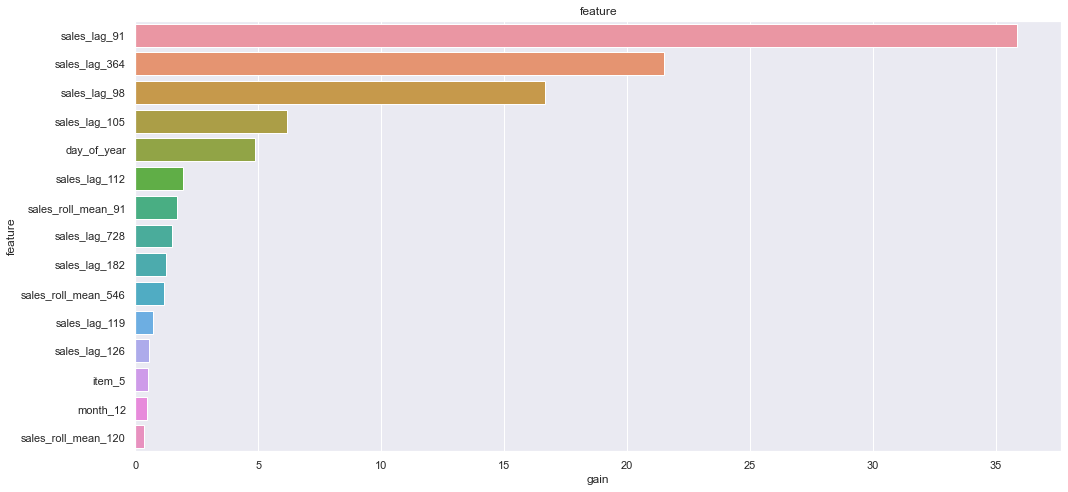

,feature,split,gain
6,sales_lag_91,6272,35.875947
13,sales_lag_364,7775,21.497989
7,sales_lag_98,4603,16.665289
8,sales_lag_105,2753,6.169673
1,day_of_year,3758,4.871166
...,...,...,...
113,day_171,0,0.000000
119,day_190,0,0.000000
81,day_15,0,0.000000
238,week_of_year_25,0,0.000000


In [33]:
plot_lgb_importances(model, num=15, plot=True)

In [34]:
dff=pd.DataFrame(np.expm1(Y_val))
dff["pred"]=np.expm1(y_pred_val)
dff

,sales,pred
1484,19.0,17.241961
19744,40.0,51.970940
38004,36.0,30.182309
56264,21.0,18.846070
74524,25.0,15.090499
...,...,...
839706,67.0,66.665409
857966,27.0,23.958907
876226,60.0,63.294292
894486,46.0,31.019590


<a id = "14" ></a>
# <span style="font-family:serif; font-size:28px;"> 14. Result</span>
<a id = "Undertanding the data" ></a>

Let's find out which stores and which item the predictions belong to.

In [35]:
dff2=dff.copy()
dff2["store"]=df_copy["store"].loc[dff2.index]
dff2["item"]=df_copy["item"].loc[dff2.index]
dff2["date"]=df_copy["date"].loc[X_val.index]
dff2

,sales,pred,store,item,date
1484,19.0,17.241961,1,1,2017-01-01
19744,40.0,51.970940,1,2,2017-01-01
38004,36.0,30.182309,1,3,2017-01-01
56264,21.0,18.846070,1,4,2017-01-01
74524,25.0,15.090499,1,5,2017-01-01
...,...,...,...,...,...
839706,67.0,66.665409,10,46,2017-03-30
857966,27.0,23.958907,10,47,2017-03-30
876226,60.0,63.294292,10,48,2017-03-30
894486,46.0,31.019590,10,49,2017-03-30


**Let's examine the predictions for store==1.**

In [36]:
dff3=dff2[dff2["store"]==1].groupby(["store","date"]).agg({"sales":"sum","pred":"sum"})
dff3=dff3.reset_index()
dff3=dff3.set_index("date")
dff3

,store,sales,pred
date,,,
2017-01-01,1,2155.0,2215.095465
2017-01-02,1,1441.0,1467.163214
2017-01-03,1,1635.0,1690.558492
2017-01-04,1,1713.0,1702.455409
2017-01-05,1,1858.0,1831.608228
...,...,...,...
2017-03-26,1,2916.0,2862.013865
2017-03-27,1,1972.0,1946.454689
2017-03-28,1,2232.0,2250.173470


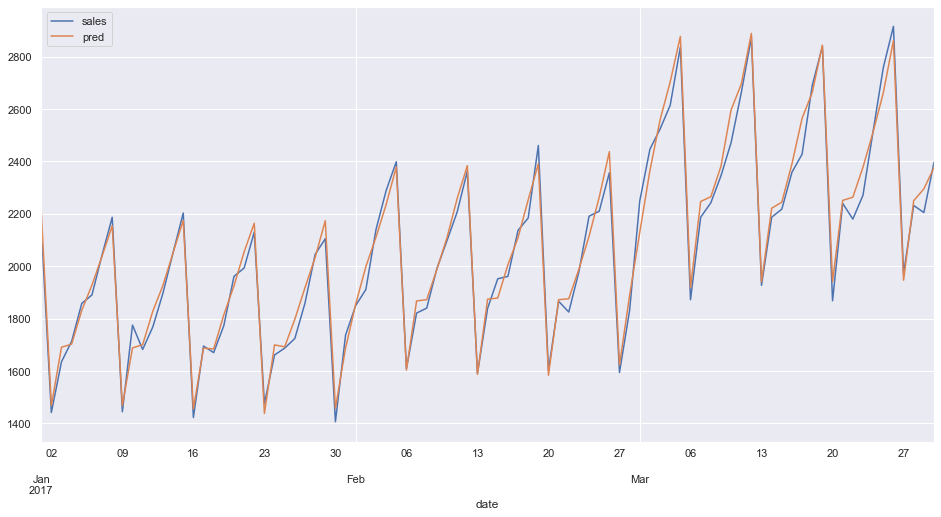

In [37]:
dff3['sales'].plot(legend=True, label="sales")
dff3['pred'].plot(legend=True, label="pred", figsize=(16, 8))
plt.show()

**Estimates and actual data largely overlap.**

**Great result 👍**

<img src="https://amessagewithabottle.com/wp-content/uploads/2019/09/moneyball-1024x550.jpg" width="500">

I hope all of you did gain some insights to Machine Learning. Some other my notebooks for Machine Learning are:

❖ **📈Transaction Forecasting - Time Series - LGBM🚀  :** [**Go to Page**](https://www.kaggle.com/code/mustafayazici/transaction-forecasting-time-series-lgbm)

❖ **House Price** Prediction, EDA, ML, Visualization : [**Go to Page**](https://www.kaggle.com/code/mustafayazici/house-price-eda-ml-visualization)

❖ **Salary** Prediction with ML Models - ⚾Baseball  : [**Go to Page**](https://www.kaggle.com/code/mustafayazici/salary-prediction-with-ml-models-basebal)

❖ **Customer Churn** Prediction : [**Go to Page**](https://www.kaggle.com/code/mustafayazici/telco-churn-prediction)

❖ **Customer Segmentation with K-Means Clustering**  : [**Go to Page**](https://www.kaggle.com/code/mustafayazici/customer-segmentation-with-k-means-clustering)

❖ **Customer Segmentation with Hierarchical Clustering**  : [**Go to Page**](https://www.kaggle.com/code/mustafayazici/customer-segmentation-with-hierarchical-clustering)


❖ **PCA & Clustering :** [**Go to Page**](https://www.kaggle.com/code/mustafayazici/makine-ogrenmesi-modeli-pca-clustering)

❖ **User Based** Recommendation : [**Go to Page**](https://www.kaggle.com/code/mustafayazici/user-based-recommendation-system)

❖ **Content Based** Recommendation : [**Go to Page**](https://www.kaggle.com/code/mustafayazici/content-based-recommendation)

❖ **ARL** Recommendation : [**Go to Page**](https://www.kaggle.com/code/mustafayazici/association-rule-learning-recommendation-system)

❖ **My Kaggle** [**Go to Page**](https://www.kaggle.com/mustafayazici/code)

❖ **My github** [**Go to Page**](https://github.com/Mustafa-YAZICI?tab=repositories)

<img src="https://i.imgflip.com/4of9h0.jpg" width="300">

Please upvote **if you liked** the kernel! 😀

KEEP KAGGLING!